In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix

import lightgbm as lgb

from IPython.display import Image
from IPython.display import Markdown, display

from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [2]:
data = pd.read_csv('data/patient_features_initial.csv')
data = data.drop(['initial_eGFR', 'initial_creatinine', 'initial_sbp', 'initial_dbp', 'initial_ldl', 
                  'initial_glucose', 'initial_hgb', 'cholesterol_drug', 
                  'diabetes_drug', 'hbp_lol_drug', 'hbp_tan_drug'], axis=1)

data.head()

,id,race,gender,age,initial_stage,initial_bp_stage,initial_cholesterol_stage,initial_diabetes_stage,Stage_Progress
0,0,Unknown,Male,70,3a,Hypertension 1,High,Healthy,True
1,1,White,Female,71,4,Hypertension 2,Optimal,Diabetes,False
2,2,White,Female,57,4,Hypertension 1,Optimal,Diabetes,True
3,3,White,Male,74,1,Hypertension 1,Optimal,Healthy,False
4,4,White,Female,50,3b,Hypertension 1,Optimal,Diabetes,True


In [3]:
# Since not much data is available, have to use smaller no. of bins 
# Based on discretisation done for log reg and random forest
discretised_data = data.copy().drop('id', axis=1)

race_map = {i : 'Black' if i == 'Black'
            else 'Non-black' for i in discretised_data['race'].unique()}
discretised_data['race'] = discretised_data['race'].map(race_map)


gender_map = {i : 'Female' if i == 'Female'
              else 'Male' for i in discretised_data['gender'].unique()}
discretised_data['gender'] = discretised_data['gender'].map(gender_map)


age_map = {i : 'Elderly' if i >= 65 
           else 'Non-elderly' for i in discretised_data['age'].unique()}
discretised_data['age'] = discretised_data['age'].map(age_map)

discretised_data = discretised_data.rename({'Stage_Progress' : 'label'}, axis=1).astype('str')

discretised_data.head()

,race,gender,age,initial_stage,initial_bp_stage,initial_cholesterol_stage,initial_diabetes_stage,label
0,Non-black,Male,Elderly,3a,Hypertension 1,High,Healthy,True
1,Non-black,Female,Elderly,4,Hypertension 2,Optimal,Diabetes,False
2,Non-black,Female,Non-elderly,4,Hypertension 1,Optimal,Diabetes,True
3,Non-black,Male,Elderly,1,Hypertension 1,Optimal,Healthy,False
4,Non-black,Female,Non-elderly,3b,Hypertension 1,Optimal,Diabetes,True


In [4]:
# Label encode for notears algo
sm_data = discretised_data.copy()
for c in sm_data.columns:
    label_enc = LabelEncoder()
    sm_data[c] = label_enc.fit_transform(sm_data[c])
    
sm_data.head()

,race,gender,age,initial_stage,initial_bp_stage,initial_cholesterol_stage,initial_diabetes_stage,label
0,1,1,0,2,1,1,1,1
1,1,0,0,4,2,3,0,0
2,1,0,1,4,1,3,0,1
3,1,1,0,0,1,3,1,0
4,1,0,1,3,1,3,0,1


/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'race', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


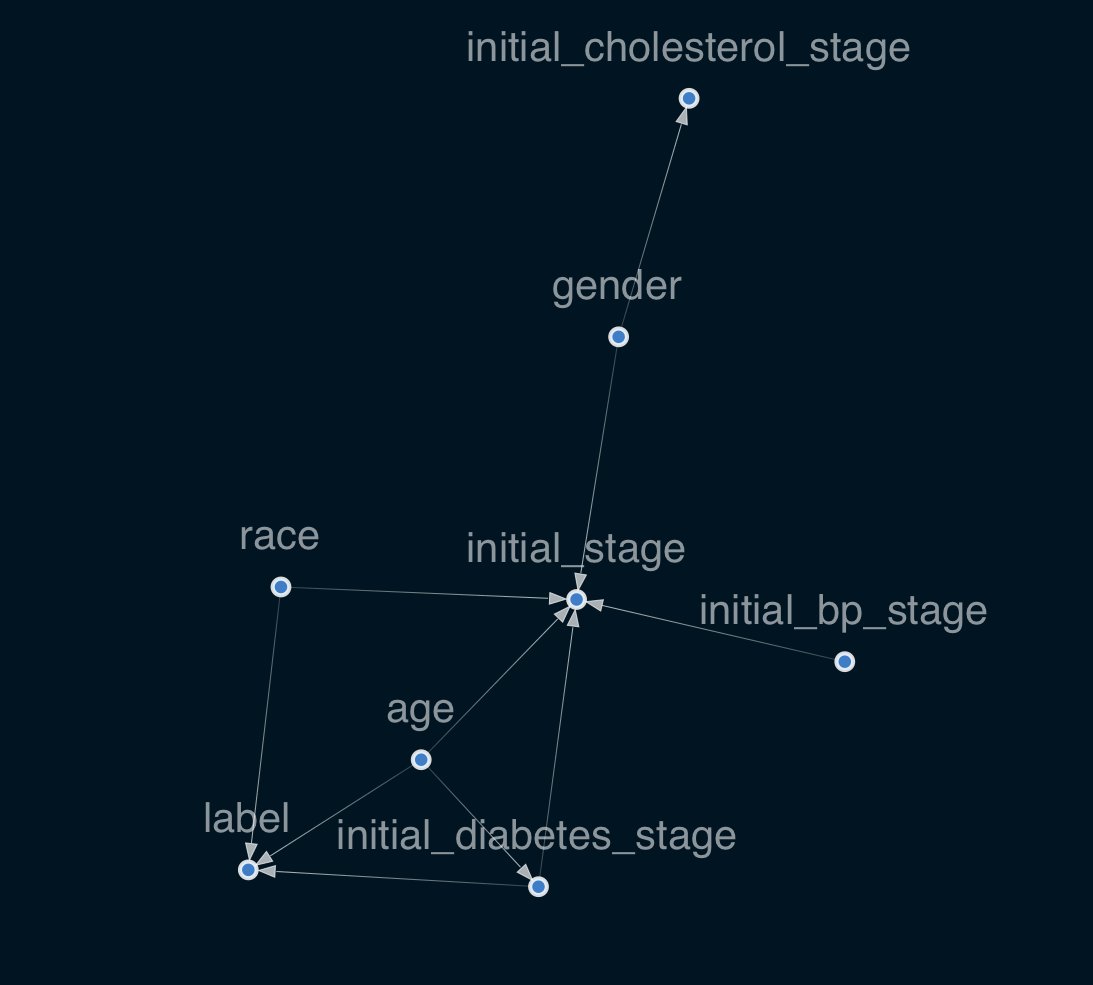

In [5]:
sm = from_pandas(sm_data)
sm.remove_edges_below_threshold(0.35)

# # Removing edges that dont make causal sense
sm.remove_edge('initial_diabetes_stage', 'race')
sm.remove_edge('race', 'initial_cholesterol_stage')
sm.remove_edge('initial_stage', 'initial_cholesterol_stage')

# # Adding edges that make sense
sm.add_edge('age', 'initial_stage')
sm.add_edge('initial_bp_stage', 'initial_stage')


# # Flipping edges that dont make causal sense
sm.remove_edge('label', 'race')
sm.add_edge('race', 'label')

sm.remove_edge('label', 'initial_diabetes_stage')
sm.add_edge('initial_diabetes_stage', 'label')


# Plot the graph
viz = plot_structure(sm, graph_attributes={"scale": "0.8"}, all_node_attributes=NODE_STYLE.WEAK, all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [6]:
bn = BayesianNetwork(sm)
bn = bn.fit_node_states(discretised_data)

seed = 111
train, test = train_test_split(discretised_data, test_size=0.2, random_state=seed)
# bn = bn.fit_cpds(train, method="MaximumLikelihoodEstimator")
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {

In [7]:
bn.cpds['label']

age                     Elderly                               Non-elderly  \
initial_diabetes_stage Diabetes             Healthy              Diabetes   
race                      Black Non-black     Black Non-black       Black   
label                                                                       
False                       0.5  0.753846  0.714286  0.614679    0.666667   
True                        0.5  0.246154  0.285714  0.385321    0.333333   

age                                                   
initial_diabetes_stage             Healthy            
race                   Non-black     Black Non-black  
label                                                 
False                      0.625  0.666667  0.641026  
True                       0.375  0.333333  0.358974

In [8]:
y_true = [1 if i == 'True' else 0 for i in train['label'].values]
y_pred = bn.predict_probability(train, node='label')['label_True'].values

threshold = 0.37

y_true = [1 if i == 'True' else 0 for i in test['label'].values]
y_pred = bn.predict_probability(test, node='label')['label_True'].values
y_pred = [1 if p >= threshold else 0 for p in y_pred]

No. of observations: 60
No. of positive obs: 21,    No. of negative obs: 39
TP: 16, TN: 19, FP: 20, FN: 5

Accuracy: 0.5833
TPR: 0.7619, TNR: 0.4872
FPR: 0.5128, FNR: 0.2381

Precision: 0.4444, Recall: 0.7619
AUC score: 0.6245, f1 score: 0.5614


<Figure size 432x288 with 0 Axes>

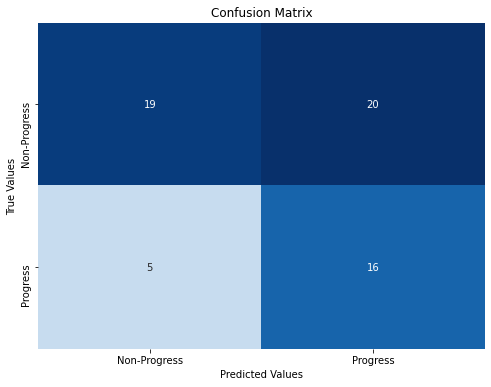

In [9]:
def calc_metrics_bn(true, pred):    
    raw_data = pd.DataFrame({'true' : true, 'pred' : pred})
    n_row = raw_data.shape[0]
    print(f'No. of observations: {n_row}')
    print(f"No. of positive obs: {raw_data[raw_data['true'] == 1].shape[0]},\
    No. of negative obs: {raw_data[raw_data['true'] == 0].shape[0]}")
    
    tp = raw_data[(raw_data['true'] == 1) & (raw_data['pred'] == 1)].shape[0]
    tn = raw_data[(raw_data['true'] == 0) & (raw_data['pred'] == 0)].shape[0]
    fp = raw_data[(raw_data['true'] == 0) & (raw_data['pred'] == 1)].shape[0]
    fn = raw_data[(raw_data['true'] == 1) & (raw_data['pred'] == 0)].shape[0]
    
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    
    print(f'\nAccuracy: {round((tp + tn) / n_row, 4)}')
    print(f'TPR: {round(tp / (tp + fn), 4)}, TNR: {round(tn / (tn + fp), 4)}')
    print(f'FPR: {round(fp / (fp + tn), 4)}, FNR: {round(fn / (fn + tp), 4)}')
    
    print(f'\nPrecision: {round(precision_score(true, pred), 4)}, Recall: {round(recall_score(true, pred), 4)}')
    print(f'AUC score: {round(roc_auc_score(true, pred), 4)}, f1 score: {round(f1_score(true, pred), 4)}')
    
    
    #Print Confusion Matrix
    plt.figure()
    cm = confusion_matrix(true, pred)
    labels = ['Non-Progress', 'Progress']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
                annot=True, fmt='d', cmap="Blues", vmin=0.2,
                cbar=False);
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    
calc_metrics_bn(y_true, y_pred)

### Inference

In [10]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

ie = InferenceEngine(bn)
marginals = ie.query()

/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {prior_type} prior. It will be ignored, use dirichlet prior for specifying pseudo_counts"
/Users/afif.muhammad/opt/anaconda3/envs/causalnex/lib/python3.7/site-packages/pgmpy/estimators/BayesianEstimator.py:155: UserWarning: pseudo count specified with k2 prior. It will be ignored, use dirichlet prior for specifying pseudo_counts
  f"pseudo count specified with {

In [11]:
# Marginal of label
marginals['label']

{'False': 0.6545229168390071, 'True': 0.3454770831609929}

In [12]:
marginals_black = ie.query({"race": "Black"})
marginals_nonblack = ie.query({"race": "Non-black"})

print("Marginal progress in stage | Black", marginals_black["label"])
print("Marginal progress in stage | Not black", marginals_nonblack["label"])

Marginal progress in stage | Black {'False': 0.664460825380369, 'True': 0.3355391746196311}
Marginal progress in stage | Not black {'False': 0.6536259936854546, 'True': 0.3463740063145454}


In [13]:
marginals_elder = ie.query({"age": "Elderly"})
marginals_nonelder = ie.query({"age": "Non-elderly"})

print("Marginal progress in stage | Elderly", marginals_elder["label"])
print("Marginal progress in stage | Not elderly", marginals_nonelder["label"])

Marginal progress in stage | Elderly {'False': 0.6746469953721534, 'True': 0.32535300462784644}
Marginal progress in stage | Not elderly {'False': 0.5986785989095259, 'True': 0.4013214010904741}


In [14]:
marginals_diabetes = ie.query({"initial_diabetes_stage": "Diabetes"})
marginals_nodiabetes = ie.query({"initial_diabetes_stage": "Healthy"})

print("Marginal progress in stage | Diabetes", marginals_diabetes["label"])
print("Marginal progress in stage | Healthy", marginals_nodiabetes["label"])

Marginal progress in stage | Diabetes {'False': 0.6925572340057825, 'True': 0.3074427659942174}
Marginal progress in stage | Healthy {'False': 0.6341628764120838, 'True': 0.3658371235879161}
